<a href="https://colab.research.google.com/github/rezaldii/InceptionV3-for-Beef-Pork-Image-Classification/blob/main/Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

## Pengumpulan Data

In [ ]:
# Pertama, install kaggle package
!pip install kaggle

In [1]:
# Buat direktori .kaggle di home directory
!mkdir ~/.kaggle

In [2]:
# Upload file kaggle.json Anda (API key Kaggle)
# Anda perlu menjalankan ini dan mengikuti petunjuk untuk mengupload file kaggle.json
from google.colab import files
files.upload()  # Pilih file kaggle.json Anda


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rezaldi","key":"91a78447712be224c61edf5c930f2eb6"}'}

In [3]:
# Salin file kaggle.json ke direktori yang baru dibuat
!cp kaggle.json ~/.kaggle/

In [4]:
# Ubah izin file agar dapat dibaca
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Sekarang Anda dapat mengunduh dataset dari Kaggle
!kaggle datasets download -d iqbalagistany/pork-meat-and-horse-meat-dataset

 99% 190M/192M [00:10<00:00, 22.5MB/s]
100% 192M/192M [00:10<00:00, 18.5MB/s]


In [6]:
# Ekstrak file zip ke folder 'Dataset'
!unzip pork-meat-and-horse-meat-dataset.zip -d Dataset

Archive:  pork-meat-and-horse-meat-dataset.zip
  inflating: Dataset/Horse Meat/IMG_20220110_105954.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_105956.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_105958.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110000.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110003.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110004.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110015.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110018.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110019.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110021.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110024.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110026.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110028.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110030.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110034.jpg  
  inflating: Dataset/Horse Meat/IMG_20220110_110043.jpg  
  inflating: Dataset/Hors

## Pembersihan data

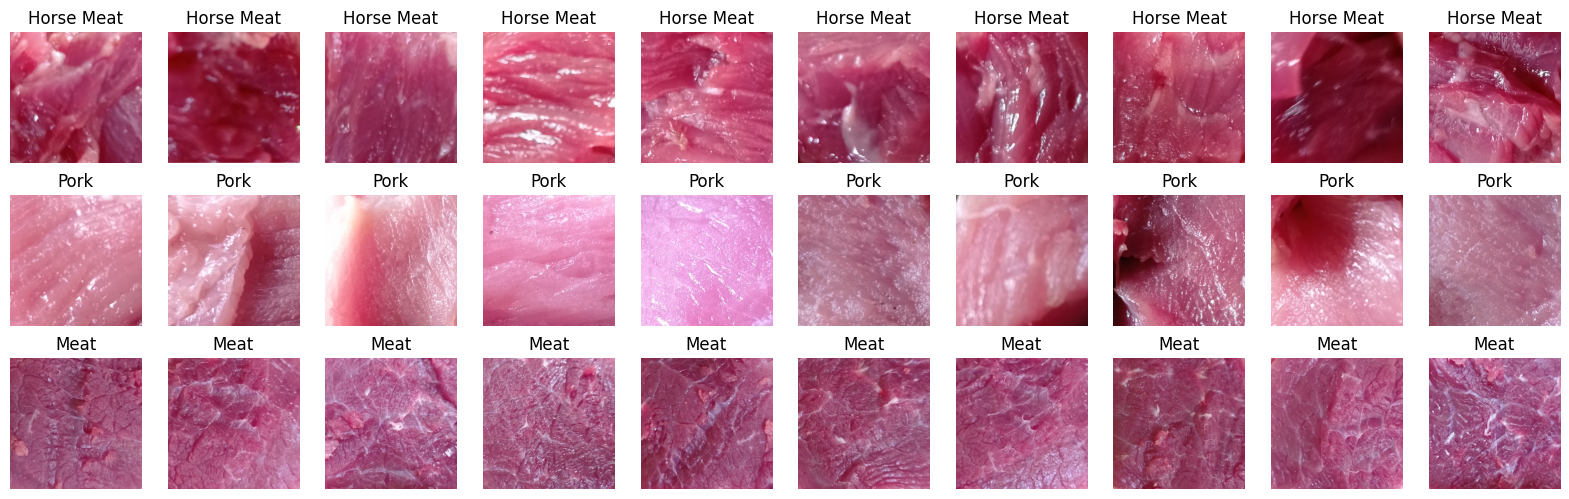

In [7]:
# Impor modul yang dibutuhkan
import os
import matplotlib.pyplot as plt

# Tentukan direktori dataset
dataset_dir = "Dataset"

# Dapatkan daftar subdirektori (kelas)
classes = os.listdir(dataset_dir)

# Buat figur dan sumbu
fig, ax = plt.subplots(len(classes), 10, figsize=(20, 6))

# Untuk setiap kelas
for i, c in enumerate(classes):
  # Dapatkan daftar nama file gambar
  images = os.listdir(os.path.join(dataset_dir, c))
  # Untuk setiap gambar
  for j, img in enumerate(images[:10]):
    # Baca gambar sebagai array
    image = plt.imread(os.path.join(dataset_dir, c, img))
    # Tampilkan gambar di sumbu yang sesuai
    ax[i, j].imshow(image)
    # Hilangkan sumbu
    ax[i, j].axis("off")
    # Jika gambar pertama di baris, tambahkan label kelas
    if j == 0:
      ax[i, j].set_ylabel(c)
    # Tambahkan judul gambar dengan nama kelas
    ax[i, j].set_title(c)

# Tampilkan figur
plt.show()

### Menghapus Class Horse Meat

In [8]:
import os
import shutil
import tensorflow as tf

horse_meat_dir = os.path.join(dataset_dir, "Horse Meat")

if os.path.exists(horse_meat_dir):
    # Hapus folder Horse Meat beserta isinya
    shutil.rmtree(horse_meat_dir)
    print("Folder Horse Meat telah dihapus.")

else:
    print("Folder Horse Meat tidak ditemukan.")

# Verifikasi folder Horse Meat sudah terhapus
print(f"Folders di {dataset_dir}: {os.listdir(dataset_dir)}")

Folder Horse Meat telah dihapus.
Folders di Dataset: ['Pork', 'Meat']


### Mengubah nama label

In [9]:
import os
import tensorflow as tf

pork_dir = os.path.join(dataset_dir, "Pork")
meat_dir = os.path.join(dataset_dir, "Meat")

# Ubah nama folder Pork menjadi Babi
new_pork_dir = os.path.join(dataset_dir, "Babi")
os.rename(pork_dir, new_pork_dir)

# Ubah nama folder Meat menjadi Sapi
new_meat_dir = os.path.join(dataset_dir, "Sapi")
os.rename(meat_dir, new_meat_dir)

# Verifikasi perubahan nama folder
print(f"Folders di {dataset_dir}: {os.listdir(dataset_dir)}")

Folders di Dataset: ['Babi', 'Sapi']


## Label encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

# Dapatkan daftar subdirektori (kelas)
labels = os.listdir(dataset_dir)

# Membuat objek LabelEncoder
label_encoder = LabelEncoder()

# Melakukan label encoding pada labels
encoded_labels = label_encoder.fit_transform(labels)

# Menampilkan hasil label encoding beserta labelnya
for label, encoded_label in zip(labels, encoded_labels):
    print(f"{label}: {encoded_label}")

Babi: 0
Sapi: 1


### augmentasi data

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
rescale_factor = 1./255
target_size = (299, 299)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=rescale_factor,  # Rescale pixel values to [0,1]
    horizontal_flip=True,  # Randomly flip inputs horizontally
    vertical_flip=True  # Randomly flip inputs vertically
)
val_datagen = ImageDataGenerator(
    rescale=rescale_factor,  # Rescale pixel values to [0,1]
    horizontal_flip=True,  # Randomly flip inputs horizontally
    vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=rescale_factor)

## pembagian data 70-15-15

In [12]:
import os
import numpy as np
import shutil

# Definisikan rasio split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Path untuk direktori train, validation, dan test
train_dir = "/content/Dataset/train"
val_dir = "/content/Dataset/validation"
test_dir = "/content/Dataset/test"

# Membuat direktori jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Membagi data untuk setiap kelas
for label in labels:
    label_dir = os.path.join(dataset_dir, label)
    images = os.listdir(label_dir)
    num_images = len(images)

    # Acak urutan gambar
    np.random.shuffle(images)

    # Hitung jumlah data untuk masing-masing set
    num_train = int(train_ratio * num_images)
    num_val = int(val_ratio * num_images)
    num_test = int(test_ratio * num_images)

    # Bagi data menjadi train, validation, dan test sets
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    # Pindahkan gambar ke masing-masing direktori
    for img in train_images:
        src = os.path.join(label_dir, img)
        dst = os.path.join(train_dir, label)
        os.makedirs(dst, exist_ok=True)
        shutil.copy(src, dst)

    for img in val_images:
        src = os.path.join(label_dir, img)
        dst = os.path.join(val_dir, label)
        os.makedirs(dst, exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(label_dir, img)
        dst = os.path.join(test_dir, label)
        os.makedirs(dst, exist_ok=True)
        shutil.copy(src, dst)

# Verifikasi jumlah data dalam setiap set
print("Jumlah data train (Sapi):", len(os.listdir(os.path.join(train_dir, 'Sapi'))))
print("Jumlah data train (Babi):", len(os.listdir(os.path.join(train_dir, 'Babi'))))
print("Jumlah data validation (Sapi):", len(os.listdir(os.path.join(val_dir, 'Sapi'))))
print("Jumlah data validation (Babi):", len(os.listdir(os.path.join(val_dir, 'Babi'))))
print("Jumlah data test (Sapi):", len(os.listdir(os.path.join(test_dir, 'Sapi'))))
print("Jumlah data test (Babi):", len(os.listdir(os.path.join(test_dir, 'Babi'))))

Jumlah data train (Sapi): 80
Jumlah data train (Babi): 90
Jumlah data validation (Sapi): 17
Jumlah data validation (Babi): 19
Jumlah data test (Sapi): 18
Jumlah data test (Babi): 20


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define train, validation, and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 170 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


# create mode

## create model1 (skenario 1: Mengganti filter nxn dengan filter 1xn dan nx1 berturut-turut dan menambahkan teknik Normalisasi Batch Sebelum Aktivasi (Pre-Activation BN))

In [14]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [15]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad, Nadam
from tensorflow.keras.activations import relu, elu, tanh

def build_model(hp):
    # Menentukan hyperparameter
    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01])
    filters_conv2d = hp.Choice('filters_conv2d', values=[16, 32, 64, 128, 256])
    dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    units_dense = hp.Choice('units_dense', values=[16, 32, 64, 128, 256])
    layers_freeze = hp.Int('layers_freeze', min_value=0, max_value=20)
    kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    pool_size = hp.Choice('pool_size', values=[2, 3, 4])
    use_batch_norm = hp.Choice('use_batch_norm', values=[True, False])
    activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'elu', 'tanh'])
    optimizer = hp.Choice('optimizer', values=['rmsprop', 'adam', 'sgd', 'adagrad', 'nadam'])

    # Memuat InceptionV3 sebagai base model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Membekukan layer dasar
    for layer in base_model.layers[:-layers_freeze]:
        layer.trainable = False

    # Menambahkan layer-layer baru
    x = base_model.output
    x = Conv2D(filters=filters_conv2d, kernel_size=(kernel_size, kernel_size), padding='same', activation=activation)(x)
    if use_batch_norm:
        x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)
    x = Flatten()(x)
    x = Dense(units_dense, activation=activation)(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(2, activation='softmax')(x)

    # Membuat model
    model = Model(inputs=base_model.input, outputs=output)

    # Mengompilasi model dengan optimizer dan loss function yang sesuai
    if optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    else:  # nadam
        optimizer = Nadam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# Definisikan tuner dengan teknik Random Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='random_search_results',
    project_name='hyperparameter_tuning'
)

# Define number of training steps and validation steps
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = val_generator.samples // batch_size

# Jalankan proses hyperparameter tuning
tuner.search(train_generator,
             steps_per_epoch=train_steps_per_epoch,
             validation_data=val_generator,
             validation_steps=val_steps_per_epoch,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

# Dapatkan model dengan hyperparameter terbaik
best_model = tuner.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 03m 05s]
val_loss: 0.2607575058937073

Best val_loss So Far: 0.0
Total elapsed time: 00h 24m 22s


In [16]:
# Dapatkan hyperparameter terbaik
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Tampilkan hyperparameter terbaik
print("Hyperparameter terbaik:")
print(f"Learning rate: {best_hyperparameters.get('learning_rate')}")
print(f"Jumlah filter Conv2D: {best_hyperparameters.get('filters_conv2d')}")
print(f"Dropout rate: {best_hyperparameters.get('dropout_rate')}")
print(f"Jumlah unit Dense: {best_hyperparameters.get('units_dense')}")
print(f"Jumlah layer yang dibekukan: {best_hyperparameters.get('layers_freeze')}")
print(f"Kernel size: {best_hyperparameters.get('kernel_size')}")
print(f"Pool size: {best_hyperparameters.get('pool_size')}")
print(f"Menggunakan BatchNormalization: {best_hyperparameters.get('use_batch_norm')}")
print(f"Activation function: {best_hyperparameters.get('activation')}")
print(f"Optimizer: {best_hyperparameters.get('optimizer')}")

Hyperparameter terbaik:
Learning rate: 0.01
Jumlah filter Conv2D: 64
Dropout rate: 0.2
Jumlah unit Dense: 32
Jumlah layer yang dibekukan: 12
Kernel size: 5
Pool size: 2
Menggunakan BatchNormalization: 1
Activation function: elu
Optimizer: rmsprop


In [17]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [18]:
# Train the model
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch
)

Epoch 1/10
5/5 [==============================] - 12s 2s/step - loss: 0.0375 - accuracy: 0.9855 - val_loss: 1.5274e-07 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 4s 838ms/step - loss: 0.0173 - accuracy: 0.9855 - val_loss: 0.1538 - val_accuracy: 0.9688
Epoch 3/10
5/5 [==============================] - 4s 834ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 8.7203e-05 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 5s 895ms/step - loss: 0.0306 - accuracy: 0.9928 - val_loss: 0.1153 - val_accuracy: 0.9688
Epoch 5/10
5/5 [==============================] - 4s 939ms/step - loss: 0.0175 - accuracy: 0.9855 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 5s 1s/step - loss: 2.0066e-04 - accuracy: 1.0000 - val_loss: 9.0618e-04 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 4s 804ms/step - loss: 4.5728e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.00

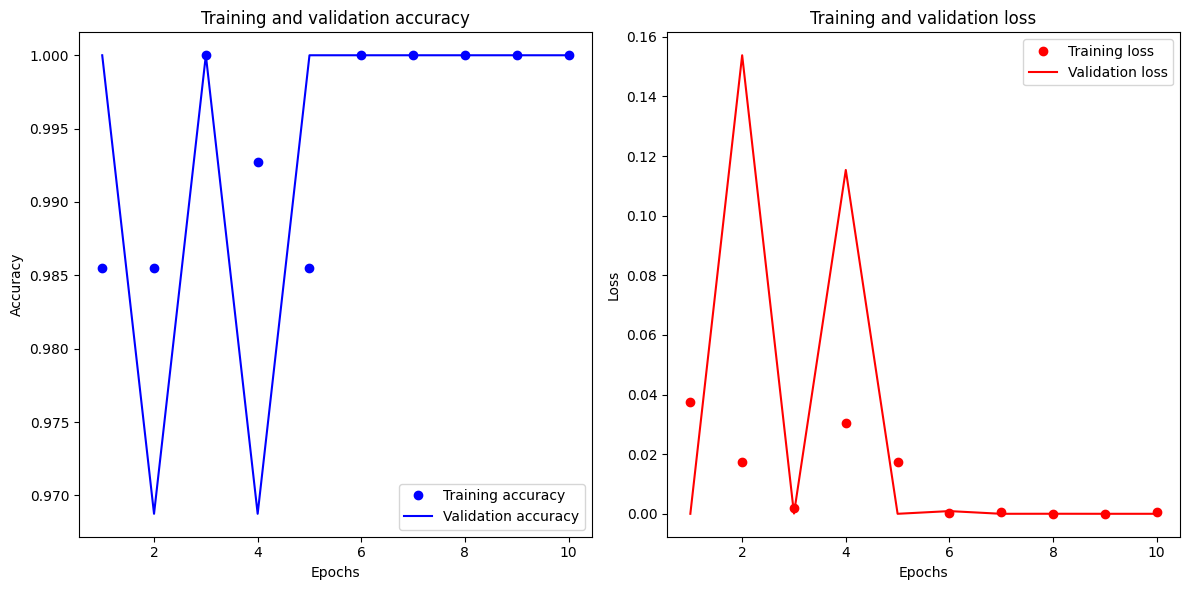

In [21]:
import matplotlib.pyplot as plt

# Mengambil nilai akurasi dan loss untuk data training dan validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Membuat plot untuk akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Membuat plot untuk loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Evaluasi model

2/2 [==============================] - 4s 3s/step


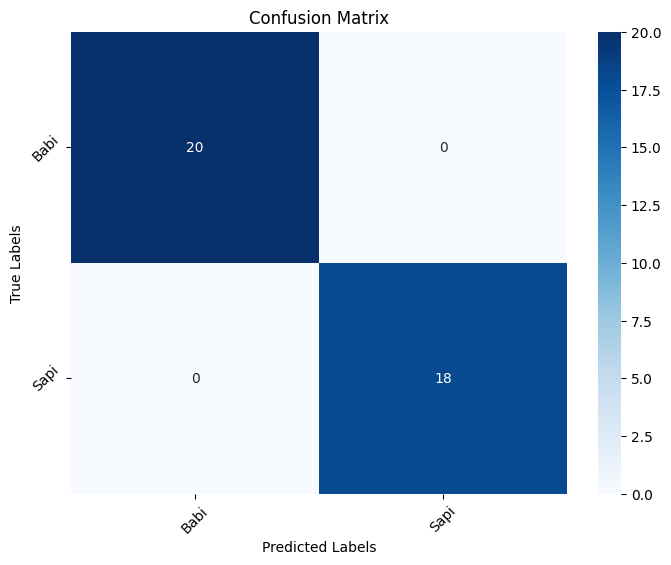

              precision    recall  f1-score   support

        Babi       1.00      1.00      1.00        20
        Sapi       1.00      1.00      1.00        18

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict probabilities for test set
y_pred_prob = best_model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = test_generator.class_indices.keys()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Print classification report
# print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))